## Libraries Used

In [24]:
# Data Handling
import pandas as pd
import numpy as np
from collections import Counter # import Counter to count word frequencies

# Text Processing
import string
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords, words
import contractions
from textblob import TextBlob, download_corpora
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Display Formatting
from IPython.display import display, HTML

# NLTK & TextBlob Downloads
download_corpora.download_all() 
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')  

[nltk_data] Downloading package brown to /Users/mohammad/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package words to /Users/mohammad/nltk_data...
[nltk_data]   Packa

True

## Dataset extraction and organization
### Load and combine all datasets

In [14]:
# Load datasets
dataset1 = pd.read_csv('data/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset2 = pd.read_csv('data/imdb_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset3 = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])

# Combine datasets
combined_dataset = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)

# Ensure correct column ordering
combined_dataset = combined_dataset[['Review', 'Sentiment']]

# Convert Sentiment column to a centered string format 
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).apply(lambda x: f"{x:^5}")

# Display first 10 rows
display(combined_dataset.head(10)) 

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


## Data Cleaning and Preparation




In [ ]:
# Load and basic cleaning
combined_dataset = combined_dataset.drop_duplicates(subset=['Review'])  # Removing duplicates
print("How many null our dataset has?", combined_dataset.isnull().sum().to_string())  # Checking for missing values
combined_dataset['Review'] = combined_dataset['Review'].str.lower()  # Converting to lowercase



# Tokenization (Returns List)
def tokenize_text(text):
    if isinstance(text, str):
        return re.findall(r'\b\w+\b', text.lower())  # regex for more precise tokenization
    return text

combined_dataset["Tokenized_Review"] = combined_dataset["Review"].apply(tokenize_text)


# Normalize Contractions
def normalize_contractions(tokens):
    if isinstance(tokens, list):
        return [contractions.fix(token) for token in tokens]
    return tokens

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(normalize_contractions)


# remove Punctuation, special Characters, and numbers in one place, better and faster than multiple filters. also removes single characters and non-alphabetic characters
# multiple filters for each step is going to slow down the process by way more (before: 5mins 30sec, after: 2min 4sec)
def clean_tokens(tokens):
    if isinstance(tokens, list):
        return [token for token in tokens if token.isalpha() and len(token) > 1] 
    return tokens

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(clean_tokens)


# Stopword Removal(important negation words (e.g., “not”, “never”) were kept preserving sentiment meaning)
important_words = {
    "not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere",
    "isn’t", "wasn’t", "aren’t", "weren’t", "doesn’t", "didn’t", "hasn’t", 
    "hadn’t", "won’t", "wouldn’t", "can’t", "couldn’t", "shouldn’t", "mustn’t"
}

stopwords = set(STOPWORDS) - important_words

def remove_stopwords(tokens): # remove stopwords
    if isinstance(tokens, list):
        return [token for token in tokens if token not in stopwords]
    return tokens

combined_dataset["Tokenized_Review"] = combined_dataset["Tokenized_Review"].apply(remove_stopwords)


# Spell Correction
spell = SpellChecker()
nltk_words_set = set(words.words())  # load known words from NLTK, and spell check those against ours, another reason for slow process.

def correct_spelling(tokens):
    if isinstance(tokens, list):
        return [word if word in nltk_words_set else spell.correction(word) or word for word in tokens]
    return tokens

combined_dataset["Tokenized_Review"] = combined_dataset["Tokenized_Review"].apply(correct_spelling)


# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    if isinstance(tokens, list):
        return [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(lemmatize_text)


# Convert cleaned token list back into sentences
combined_dataset['Review'] = combined_dataset['Tokenized_Review'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
combined_dataset['Review'].head()

How many null our dataset has? Review       0
Sentiment    0


0                    no way plug u unless go converter
1                            good case excellent value
2                                        great jawbone
3    tied charger conversation lasting minute major...
4                                            mic great
Name: Review, dtype: object

## Exploratory Data Analysis
### Visualizing and analyzing sentiment distribution.

### Use bar charts 
>to show positive vs. negative sentiments.

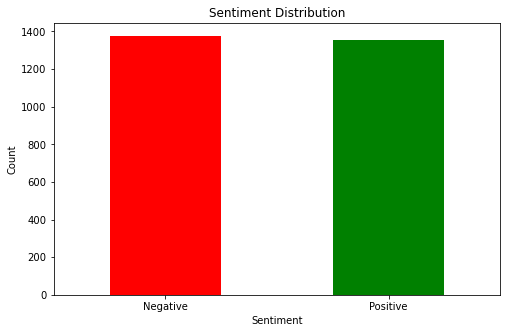

In [16]:
# Count sentiment occurrences
sentiment_counts = combined_dataset['Sentiment'].value_counts()

# Plot the sentiment distribution
sentiment_counts.plot(kind="bar", color=["red", "green"], figsize=(8,5))

# Set labels
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")

# Show plot
plt.show()

### Distribution of review lengths
>Histogram showing text lenght distribution

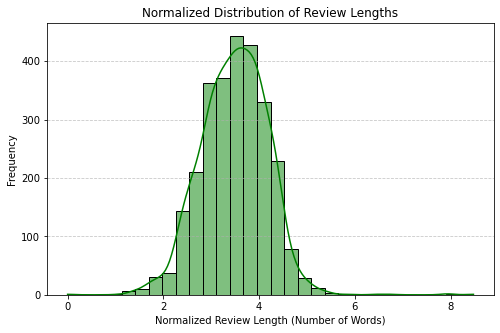

In [ ]:
# Apply log transformation to normalize review length distribution
Normalized_Review_Length = np.log1p(combined_dataset["Review"].apply(len))  # log1p avoids log(0) error

# Plot histogram of log-transformed review lengths
plt.figure(figsize=(8, 5))
sns.histplot(Normalized_Review_Length, bins=30, kde=True, color="green", edgecolor="black")
plt.xlabel("Normalized Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Normalized Distribution of Review Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Word Cloud for Most Frequent Word
>Generating word clouds for both positive and negative sentiments

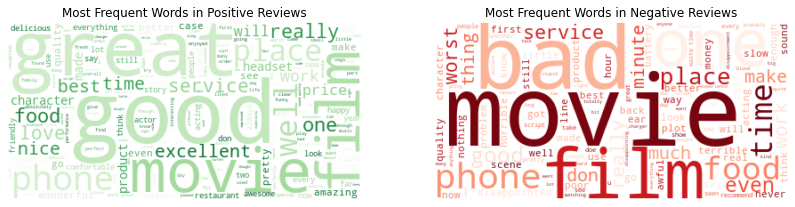

In [18]:
# Create WordCloud objects without stopwords
wc_positive = WordCloud(background_color="white", max_words=200, colormap="Greens")
wc_negative = WordCloud(background_color="white", max_words=200, colormap="Reds")

# Ensure Sentiment column is properly formatted
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).str.strip()

# Generate word clouds
positive_reviews = ' '.join(combined_dataset[combined_dataset["Sentiment"] == "1"]["Review"].tolist())  
negative_reviews = ' '.join(combined_dataset[combined_dataset["Sentiment"] == "0"]["Review"].tolist())  

positive_wc = wc_positive.generate(positive_reviews)
negative_wc = wc_negative.generate(negative_reviews)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Reviews")

plt.show()


### Term Frequency Analysis
>Identifing most common words in positive and negative reviews.

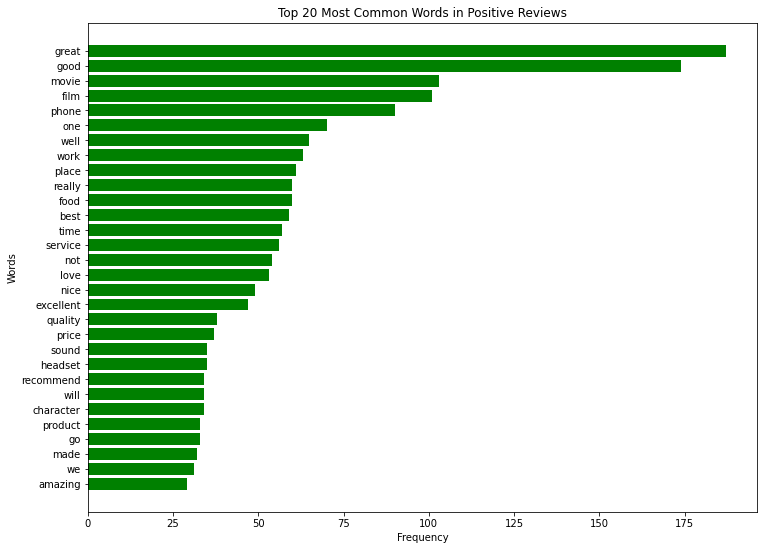

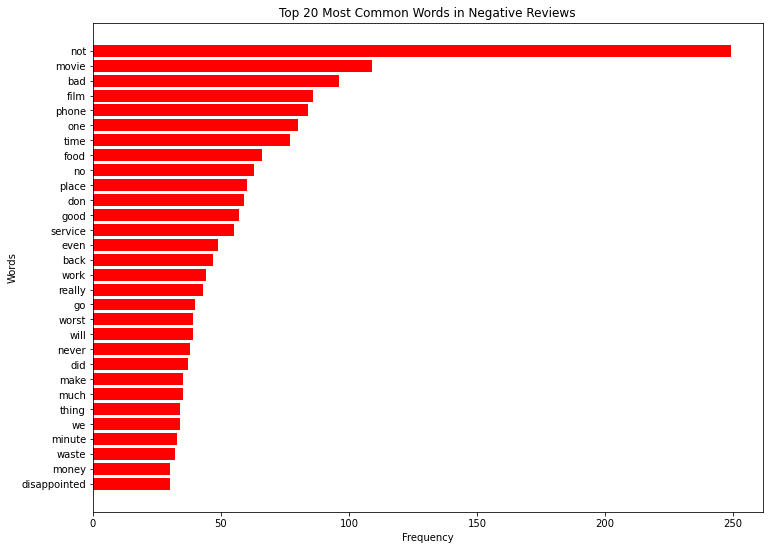

In [ ]:
combined_dataset['Review'] = combined_dataset['Review']

# Tokenize words from positive and negative reviews 
positive_words = ' '.join(combined_dataset[combined_dataset['Sentiment'].str.strip() == '1']['Review']).split() # get postive reviews from dataset using the 1 indicator
negative_words = ' '.join(combined_dataset[combined_dataset['Sentiment'].str.strip() == '0']['Review']).split() # get negative reviews from dataset using the 0 indicator

positive_word_freq = Counter(positive_words) # count positive words 
negative_word_freq = Counter(negative_words) # count negative words
top_positive_words = positive_word_freq.most_common(30) # get the top 30 most used words in positive reviews
top_negative_words = negative_word_freq.most_common(30) # get the top 30 most used words in negative reviews

df_positive = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency']) # DF for positive words
df_negative = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency']) # DF for negative words

# plotting
plt.figure(figsize=(12, 9))
plt.barh(df_positive['Word'], df_positive['Frequency'], color='green')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Positive Reviews")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 9))
plt.barh(df_negative['Word'], df_negative['Frequency'], color='red')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Negative Reviews")
plt.gca().invert_yaxis()
plt.show()

## Model Selection


### Splitting data for use in training and optimizing model(s)

In [20]:
train_data, test_data = train_test_split(combined_dataset, test_size=0.2, random_state=42)

 ### Vader
 >Leveraging a rule-based model to assess sentiment.

In [ ]:
# Convert sentiment labels to integer (0 = Negative, 1 = Positive)
combined_dataset['Sentiment'] = combined_dataset['Sentiment'].astype(int)

# Initialize VADER
model_vader = SentimentIntensityAnalyzer()

# Apply VADER Sentiment scores ONLY on the test set
test_data['VADER_compound'] = test_data['Review'] \
    .apply(lambda review: model_vader.polarity_scores(review)['compound']) # Computes VADER compound scores for each review (ranging from -1 to 1)

test_data['VADER_Prediction'] = test_data['VADER_compound'] \
    .apply(lambda score: 1 if score >= 0.05 else 0) # Converts scores into binary sentiment labels (1 = positive, 0 = negative)

vader_accuracy = accuracy_score(test_data['Sentiment'].astype(int), test_data['VADER_Prediction'].astype(int)) # Calculate VADER model accuracy as the percentage of correct predictions.
print(f"VADER Accuracy: {vader_accuracy:.2%}")

VADER Accuracy: 78.43%


### Logisitic Regression 
>Training a supervised learning model for sentiment classification

In [ ]:
combined_dataset['Review'] # reviews from dataset

vectorizer = TfidfVectorizer(max_features=10000) # turn text into numbers and keep top 10k words
x = vectorizer.fit_transform(combined_dataset['Review']) # create TF-IDF matrix, which is a matrix that measuires the importance of each word
y = combined_dataset['Sentiment'] # target variable (0 = negative, 1 = positive)

x_train = vectorizer.transform(train_data['Review']) # use dataset to train model 
x_test = vectorizer.transform(test_data['Review']) # use dataset to test model
y_train = train_data['Sentiment'] # target variable for training set
y_test = test_data['Sentiment'] # target variable for test set

model = LogisticRegression() # initialize Logistic Regression model from scikit-learn
model.fit(x_train, y_train) # train model on training sets by initializing weights and biases and then optimizing them by minimizing the loss function which is how wrong the model is
y_pred = model.predict(x_test) # from the trained model, predict the sentiment of the test set
accuracy = accuracy_score(y_test, y_pred) # calculate accuracy
accuracy = accuracy*100 # convert to percentage
print(f"Logisitic Regression Accuracy: {accuracy:.2f}%")

joblib.dump(model, "logistic_regression.pkl") # to save the model for later use 
joblib.dump(vectorizer, "tfidf_vectorizer.pkl") # to save the vectorizer for later use

Logisitic Regression Accuracy: 80.62%


['tfidf_vectorizer.pkl']

## Model Analysis
> VADER vs Logisitic Regression comparsion by using a variety of testing methods.

### Classifcation Report
>provides a detailed performance summary of a classification model. It includes key metrics such as precision, recall, F1-score, and support for each class.

In [25]:
# Extract true sentiment labels and VADER-predicted labels
y_true_vader = test_data['Sentiment'].astype(int)  
y_pred_vader = test_data['VADER_Prediction']  

# Generate a classification report to evaluate VADER's performance
# The report includes precision, recall, F1-score, and support for each sentiment category
vader_report = classification_report(y_true_vader, y_pred_vader, target_names=['Negative', 'Positive'])

# generate prediction for test set trained on LR model
lr_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

# Format reports to be displayed next to each other in an HTML table
formatted_report = f"""
<table style='width:100%;'>
    <tr>
        <th style='text-align:center;'>VADER Classification Report</th>
        <th style='text-align:center;'>Logistic Regression Classification Report</th>
    </tr>
    <tr>
        <td style='vertical-align:top; padding-right:20px;'><pre>{vader_report}</pre></td>
        <td style='vertical-align:top;'><pre>{lr_report}</pre></td>
    </tr>
</table>
"""

# Display the reports side by side
display(HTML(formatted_report))

VADER Classification Report,Logistic Regression Classification Report
precision recall f1-score support Negative 0.80 0.75 0.77 270 Positive 0.77 0.82 0.79 277 accuracy 0.78 547 macro avg 0.79 0.78 0.78 547 weighted avg 0.79 0.78 0.78 547,precision recall f1-score support Negative 0.81 0.79 0.80 270 Positive 0.80 0.82 0.81 277 accuracy 0.81 547 macro avg 0.81 0.81 0.81 547 weighted avg 0.81 0.81 0.81 547


### Confusion Matrix
>Essential for analyzing false positives and false negatives.

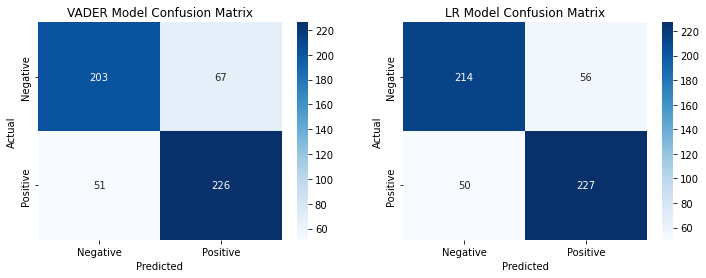

In [ ]:
# Generate a confusion matrix visualization for the VADER model
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(test_data['Sentiment'].astype(int), test_data["VADER_Prediction"]),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VADER Model Confusion Matrix")

cm = confusion_matrix(y_test, y_pred) # confusion matrix for test set trained on LR model
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LR Model Confusion Matrix")
plt.show()

### Threshold-Based Accuracy
>Measures how often model sentiment matches labels.

In [29]:
# use accuracy_score from sklearn to calculate accuracy of models by using data that was predicted when implementing and training models
# Print VADER model results again for analysis
print("=== VADER Sentiment Analysis Results ===")
print(f"VADER Accuracy: {vader_accuracy:.2%}")

# Print Logistic Regression model results again for analysis
print("\n=== Logistic Regression Sentiment Analysis Results ===")
print(f"Logistic Regression Accuracy: {accuracy:.2f}%")

=== VADER Sentiment Analysis Results ===
VADER Accuracy: 78.43%

=== Logistic Regression Sentiment Analysis Results ===
Logistic Regression Accuracy: 80.62%


### Mean Squared Error (MSE) 
>Measures how close model's scores are to actual sentiment.

In [ ]:
# Compute Mean Squared Error (MSE) for VADER predictions using NumPy
# MSE measures the average squared difference between true sentiment labels (0 or 1) and VADER's continuous compound scores (-1 to 1)
mse_vader = np.mean((test_data['Sentiment'].astype(int) - test_data['VADER_compound']) ** 2)  

y_test = y_test.astype(int) # same thing for vader but using the assigned test set
y_pred = y_pred.astype(int)
mse_lr = np.mean((y_test - y_pred) ** 2)  # Compute MSE for Logistic Regression

# Print VADER MSE Results
print("=== VADER Sentiment Analysis MSE Results ===")
print(f"VADER Mean Squared Error (MSE): {mse_vader:.4f}")

# Print Logistic Regression MSE Results
print("\n=== Logistic Regression MSE Results ===")
print(f"Logistic Regression Mean Squared Error (MSE): {mse_lr:.4f}")

=== VADER Sentiment Analysis MSE Results ===
VADER Mean Squared Error (MSE): 0.2765

=== Logistic Regression MSE Results ===
Logistic Regression Mean Squared Error (MSE): 0.1938


### Qualitative Sentiment Prediction Analysis
>Showing VADER and Logistic Regression on sample reviews.

In [31]:
def predict_sentiment_vader(text): # Creating function to Predict some Custom Sentences by Applying VADER Model (0 = negative, 1 = positive)
    score = model_vader.polarity_scores(text)['compound']
    sentiment = 1 if score >= 0.05 else 0
    return sentiment, score


def predict_sentiment_LR(text): # creating function to predict sentiment (0 = negative, 1 = positive)
    vectorized_text = vectorizer.transform([text])
    sentiment = model.predict(vectorized_text)[0]
    return sentiment

def sentiment_score_LR(text): # creating function to see exactly how positive or negative a review is 
    vectorized_text = vectorizer.transform([text])
    sentiment_score = model.decision_function(vectorized_text)[0]
    return sentiment_score

# Sample reviews for testing both models
dummy_reviews = [
    "This product is really cool",
    "This movie sucked",
    "I hate this",
    "Had a really good time",
    "My son and I thought it was just okay",
    "Where can I see more of this?"
]

# Print results for both models
print("\nShowing VADER and Logistic Regression on sample reviews:")
print(f"{'Review':<50}{'VADER Sentiment':<20}{'VADER Score':<15}{'LR Sentiment':<15}{'LR Score'}")
print("="*110)

for review in dummy_reviews:
    vader_sentiment, vader_score = predict_sentiment_vader(review)
    lr_sentiment = predict_sentiment_LR(review)
    lr_score = sentiment_score_LR(review)

    print(f"{review:<50}{vader_sentiment:<20}{vader_score:.2f}{'':<10}{lr_sentiment:<15}{lr_score:.2f}")
    
print("\nTable completed.")


Showing VADER and Logistic Regression on sample reviews:
Review                                            VADER Sentiment     VADER Score    LR Sentiment   LR Score
This product is really cool                       1                   0.38          1              1.00
This movie sucked                                 0                   -0.46          0              -0.54
I hate this                                       0                   -0.57          0              -0.92
Had a really good time                            1                   0.49          1              1.23
My son and I thought it was just okay             1                   0.23          0              -0.05
Where can I see more of this?                     0                   0.00          1              0.21

Table completed.


### Spearman/Pearson Correlation 
>Measures how well model scores align with actual sentiment.


In [34]:
# Ensure Sentiment column is of integer type
test_data['Sentiment'] = test_data['Sentiment'].astype(int)

# Compute Pearson correlation (measures the strength of the linear relationship between sentiment labels and VADER scores)
pearson_corr_vader = test_data['Sentiment'].corr(test_data['VADER_compound'], method='pearson')
# Compute Spearman correlation (measures the strength and direction of a monotonic relationship between sentiment labels and VADER scores)
spearman_corr_vader = test_data['Sentiment'].corr(test_data['VADER_compound'], method='spearman')


# Convert y_test and y_pred into pandas Series for correlation calculation
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# to measure linear relationship between prediction of sentiment and actual sentiment
pearson_corr = y_test_series.corr(y_pred_series, method='pearson')
# to measure how well the order of predictions matches the order of actual sentiment
spearman_corr = y_test_series.corr(y_pred_series, method='spearman')


# Print VADER Correlation Results
print("=== VADER Sentiment Analysis Correlation Results ===")
print(f"VADER Pearson Correlation: {pearson_corr_vader:.4f}")
print(f"VADER Spearman Correlation: {spearman_corr_vader:.4f}")

# Print Logistic Regression Correlation Results
print("\n=== Logistic Regression Correlation Results ===")
print(f"Logistic Regression Pearson Correlation: {pearson_corr:.4f}")
print(f"Logistic Regression Spearman Correlation: {spearman_corr:.4f}")


=== VADER Sentiment Analysis Correlation Results ===
VADER Pearson Correlation: 0.6302
VADER Spearman Correlation: 0.6328

=== Logistic Regression Correlation Results ===
Logistic Regression Pearson Correlation: 0.6124
Logistic Regression Spearman Correlation: 0.6124


### ROC Curve & AUC
>Measures classification performance across thresholds.

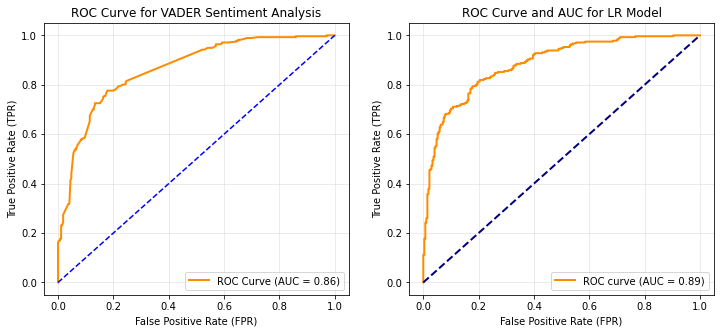

In [36]:
# Extract true sentiment labels and predicted sentiment scores (VADER compound scores)
y_true = test_data['Sentiment'].astype(int)
y_score = test_data['VADER_compound']


# Compute the ROC curve to analyze the trade-off between true positives and false positives
fpr, tpr, _ = roc_curve(y_true, y_score)

# Compute the Area Under the Curve (AUC) to quantify the overall model performancee
roc_auc = roc_auc_score(y_true, y_score)

# Plot the ROC curve for VADER
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for VADER Sentiment Analysis')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)



# predict probability of positive sentiment class
y_probability = model.predict_proba(x_test)[:,1] 
 # calculate negative sentiments that are labled as positive by the model, and calculate positive sentiments that are accurately predicted, both at different thresholds, AKA FPR and TPR and then place them on the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probability)
# get the score of how accurate the model is AKA area under the curve
roc_auc = roc_auc_score(y_test, y_probability)

# plot ROC curve for Logisisitc Regression model
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)') # 
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve and AUC for LR Model') 
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Vader vs Logistic Regression: Real-Life application experiment

## Dataset Cleaning

#### While Vader doesn't need the dataset to be cleaned since it works with raw text, we still need to do it for Logisitic Regression since we trained the model on preprocessed data. 

In [48]:
tweet_dataset = pd.read_csv('data/tweets.csv') # get tweet dataset
text_column = 'Text' # get only text since we do not care for users or anything else 
tweet_dataset = tweet_dataset[[text_column]].dropna() # keep the text and drop any values that are NaN


def preprocess_text(text): # some light cleaning 
    text = text.lower()  
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

tweet_dataset['tweets'] = tweet_dataset[text_column].apply(preprocess_text)

print(tweet_dataset['tweets'].head())

0    is upset that he cant update his facebook by t...
1    kenichan i dived many times for the ball manag...
2      my whole body feels itchy and like its on fire 
3    nationwideclass no its not behaving at all im ...
4                         kwesidei not the whole crew 
Name: tweets, dtype: object


#### VADER

In [51]:
analyzer = SentimentIntensityAnalyzer()

tweet_dataset['VADER_compound'] = tweet_dataset['tweets'].apply(lambda text: analyzer.polarity_scores(text)['compound']) # get sentiment scores for vader
tweet_dataset['VADER_Prediction'] = tweet_dataset['VADER_compound'].apply(lambda score: 1 if score >= 0.05 else 0) # label sentences with positive or negative

results = tweet_dataset[['tweets', 'VADER_compound', 'VADER_Prediction']].head()
display(results) # get first 5 rows of labeled and scored sentences

,tweets,VADER_compound,VADER_Prediction
0,is upset that he cant update his facebook by t...,-0.7269,0
1,kenichan i dived many times for the ball manag...,0.4939,1
2,my whole body feels itchy and like its on fire,-0.2500,0
3,nationwideclass no its not behaving at all im ...,-0.6597,0
4,kwesidei not the whole crew,0.0000,0


#### Logisitic Regression

In [52]:
model = joblib.load("logistic_regression.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

vectorized_tweets = vectorizer.transform(tweet_dataset['tweets']) # put tweets into vectorizer so its numerical
tweet_dataset['LR_Score'] = model.decision_function(vectorized_tweets) # Get sentiment scores for LR
tweet_dataset['LR_Prediction'] = model.predict(vectorized_tweets) # label sentence with positive or negative

results = tweet_dataset[['tweets', 'LR_Score', 'LR_Prediction']].head()
display(results) # get first 5 rows of labeled and scored sentences

,tweets,LR_Score,LR_Prediction
0,is upset that he cant update his facebook by t...,-0.489636,0
1,kenichan i dived many times for the ball manag...,-0.175660,0
2,my whole body feels itchy and like its on fire,0.227886,1
3,nationwideclass no its not behaving at all im ...,-0.998843,0
4,kwesidei not the whole crew,-1.485125,0


### Visualizing Results

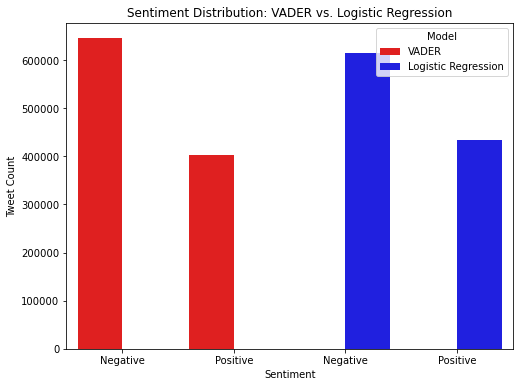

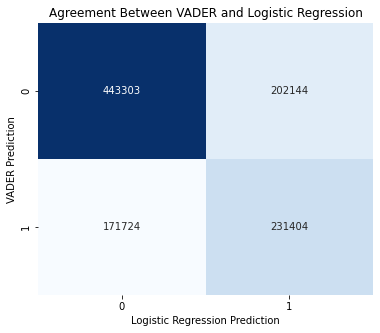

In [54]:
# Sentiment Distribution 
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', 
              data=tweet_dataset.melt(id_vars=['tweets'], 
              value_vars=['VADER_Prediction', 'LR_Prediction'],
              var_name='Model', 
              value_name='Sentiment'),
              hue='Model', palette={"VADER_Prediction": "red", "LR_Prediction": "blue"})
plt.xticks([0, 1, 2, 3], ['Negative', 'Positive', 'Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.title("Sentiment Distribution: VADER vs. Logistic Regression")
plt.legend(title="Model", labels=["VADER", "Logistic Regression"])
plt.show()


# Heatmap of Agreement
plt.figure(figsize=(6,5))
agreement_matrix = pd.crosstab(tweet_dataset['VADER_Prediction'], tweet_dataset['LR_Prediction'])
sns.heatmap(agreement_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Logistic Regression Prediction")
plt.ylabel("VADER Prediction")
plt.title("Agreement Between VADER and Logistic Regression")
plt.show()

### Sample random tweets to compare

In [59]:
comparsion_examples = tweet_dataset.sample(10)[['tweets', 'VADER_Prediction', 'LR_Prediction', 'VADER_compound', 'LR_Score']] # compare some random samples between the two models
display(comparsion_examples)

,tweets,VADER_Prediction,LR_Prediction,VADER_compound,LR_Score
848395,eaglesflite youre welcome,1,1,0.4588,0.101834
59812,just had hen walk by decoy no suitor in tow o...,0,0,-0.2960,-1.035580
1026922,off tosleep to dream about ice cream cones ht...,1,1,0.2500,0.598116
379798,splashman as a ska fan i know this tone well,1,1,0.5267,0.556631
918619,llc1983 thanks,1,1,0.4404,0.175011
938986,johnsto im sorry for all these questions th...,0,0,-0.0772,-0.417727
371993,last day seeing friends until august,1,0,0.4767,-0.024800
15731,i wish i was going to see there for tomorrow t...,1,1,0.4019,0.061479
836864,watching guitar hero vids on youtube,1,0,0.5574,-0.201021
510796,the theory were working on now is that the ten...,0,0,0.0000,-0.029403


### Disagreement visualizations

In [60]:
disagreement_equation = tweet_dataset[tweet_dataset['VADER_Prediction'] != tweet_dataset['LR_Prediction']][['tweets', 'VADER_Prediction', 'LR_Prediction', 'VADER_compound', 'LR_Score']] # tweets where the models disagree
compare_disagreements = disagreement_equation.sample(10) if len(disagreement_equation) > 10 else disagreement_equation # choose random 10 tweets
display(compare_disagreements)

,tweets,VADER_Prediction,LR_Prediction,VADER_compound,LR_Score
612795,dumpy dumpy dump dump im a sad girl today,0,0,-0.9136,-0.432478
455085,anyways i think im going to bed school in the ...,1,0,0.7003,-0.285317
898316,applesnfeathers ajpattzpathetic maybehilarious...,1,0,0.4215,-0.708264
590878,christft if u pick me up and u convince my mot...,1,1,0.8834,0.745084
73363,i feel like ive been hit by a tonne of bricks ...,0,1,-0.1010,0.267214
629850,patberry but you omitted my comment about its ...,0,1,-0.7351,0.122517
182281,wow i must be really bummed to compare my life...,1,1,0.5859,1.317678
919223,sooo tired and have a headacheall self inflict...,0,1,0.0000,0.881633
568992,but hearing about it makes me upset coz i wou...,1,1,0.5267,0.156089
432210,joeymcintyre come to t a m p a,0,1,0.0000,0.655587


## IGNORE: compressing dataset to push to github

In [54]:
df = pd.read_csv("data/tweets.csv")

# Save as compressed ZIP since original file is too large
df.to_csv("data/tweets_compressed.zip", index=False, compression="zip")

print("compressed and saved as 'tweets_compressed.zip'")

Dataset compressed and saved as 'tweets_compressed.zip'
